# DeepSphere using ModelNet40 dataset
### Benchmark with Cohen method S2CNN[[1]](http://arxiv.org/abs/1801.10130) and Esteves method[[2]](http://arxiv.org/abs/1711.06721) and others spherical CNNs
Multi-class classification of 3D objects, using the interesting property of rotation equivariance.

The 3D objects are projected on a unit sphere.
Cohen and Esteves use equiangular sampling, while our method use a HEAlpix sampling

Several features are collected:
* projection ray length (from sphere border to intersection [0, 2])
* cos/sin with surface normal
* same features using the convex hull of the 3D object

## 0.1 Load libs

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import shutil
import sys

os.environ["CUDA_VISIBLE_DEVICES"] = "1"  # change to chosen GPU to use, nothing if work on CPU

import numpy as np
import time
import matplotlib.pyplot as plt
import healpy as hp

In [3]:
from deepsphere import models, experiment_helper, plot, utils
from deepsphere.data import LabeledDatasetWithNoise, LabeledDataset
import hyperparameters

from ModelNet40.load_MN40 import plot_healpix_projection, ModelNet40DatasetTF, ModelNet40DatasetCache

## 0.2 Define parameters

In [4]:
Nside = 32
experiment_type = 'CNN' # 'FCN'
ename = '_'+experiment_type
datapath = '../data/ModelNet40/' # localisation of the .OFF files
proc_path = datapath[1:]

In [5]:
augmentation = 3        # number of element per file (1 = no augmentation of dataset)
nfeat = 6

#### Test projection

array([0.88494617, 0.88560784, 0.884164  , ..., 0.8833286 , 0.8847804 ,
       0.88401675], dtype=float32)

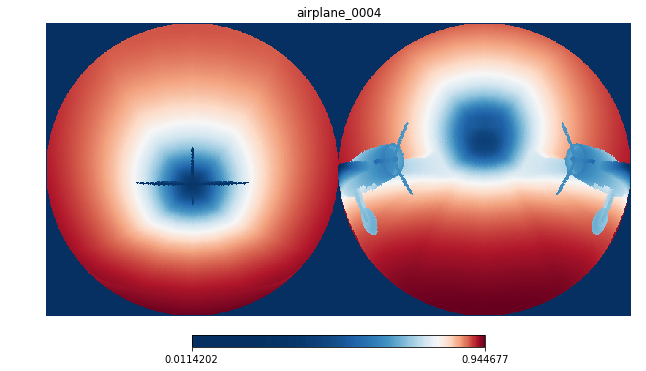

In [27]:
classes = ["airplane", "bathtub", "..."]
plot_healpix_projection(datapath+classes[0]+"/train/"+classes[0]+"_0004.off", 128, rotp = False, rot = (90,0,0))

In [40]:
import glob
classes = sorted(glob.glob(os.path.join(datapath, '*')))
classes = [os.path.split(clas)[-1] for clas in classes]
print(len(classes))

40


## 1 Load dataset

In [45]:
train_rot_dataset = ModelNet40DatasetCache(datapath, 'train', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None, experiment='deepsphere_rot_notr')


Better to keep validation and testing set in RAM, but not always possible

In [7]:
test_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, nfeat=nfeat, augmentation=3, nfile=None)

In [8]:
test_rot_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot', augmentation=3, nfile=None)

In [9]:
test_rot_no_dataset = ModelNet40DatasetCache(datapath, 'test', nside=Nside, 
                                       nfeat=nfeat, experiment='deepsphere_rot_notr', augmentation=3, nfile=None)

Try do make a tensorflow dataset object

In [41]:
train_TFDataset = ModelNet40DatasetTF(datapath, 'train', nside=Nside,
                                      nfeat=nfeat, augmentation=augmentation, nfile=None, experiment='deepsphere_rot_notr')

In [10]:
train_TFDataset.N

9843

In [27]:
from ModelNet40.load_MN40 import compute_mean_std

In [40]:
compute_mean_std(test_dataset, 'test', datapath, Nside)

100%|██████████| 7404/7404 [00:15<00:00, 488.34it/s]

[0.6679618  0.44054925 0.58357584 0.5407722  0.7610007  0.5661361 ]
[2.3372154  0.594407   0.27130878 0.21742992 0.20152076 0.24167667]


In [ ]:
dataset = train_TFDataset.get_tf_dataset(32)

In [44]:
import tensorflow as tf
from tqdm import tqdm

#dataset = tf_dataset_file(datapath, dataset, file_pattern, 32, Nside, augmentation)
data_next = dataset.make_one_shot_iterator().get_next()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
steps = train_TFDataset.N // 32 + 1
with tf.Session(config=config) as sess:
    sess.run(tf.global_variables_initializer())
    for i in tqdm(range(steps)):
        out = sess.run(data_next)
#     except tf.errors.OutOfRangeError:
#         print("Done") 


  0%|          | 0/923 [00:00<?, ?it/s]
Exception in thread Thread-39:
Traceback (most recent call last):
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?

KeyboardInterrupt



In [17]:
def transform(data):
    from ModelNet40.load_MN40 import rnd_rot
    rotator = hp.rotator.Rotator(rnd_rot(), eulertype='ZYZ')
    new_data = rotator.rotate_map_pixel(data)
    return new_data

AttributeError: 'Rotator' object has no attribute 'rotate_map_pixel'

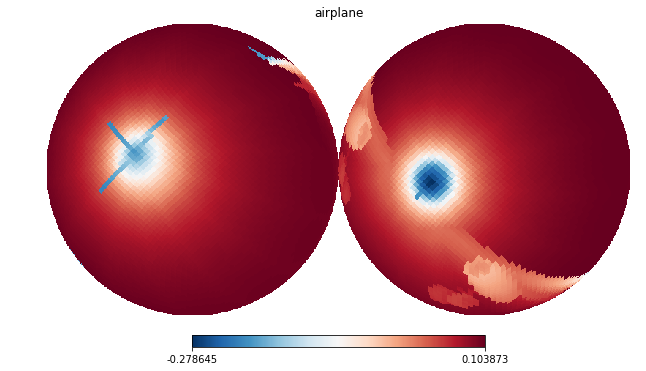

<Figure size 432x288 with 0 Axes>

In [22]:
hp.orthview(im1, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
plt.figure()
im2 = transform(im1)
hp.orthview(im2, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)

  0%|          | 10/7405 [00:01<19:07,  6.44it/s]/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  0%|          | 11/7405 [00:01<19:03,  6.46it/s]


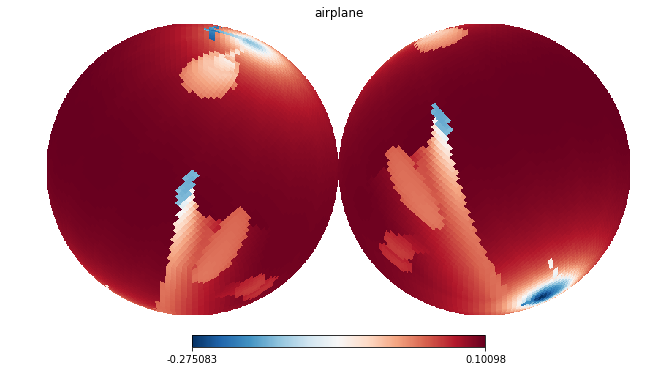

<Figure size 432x288 with 0 Axes>

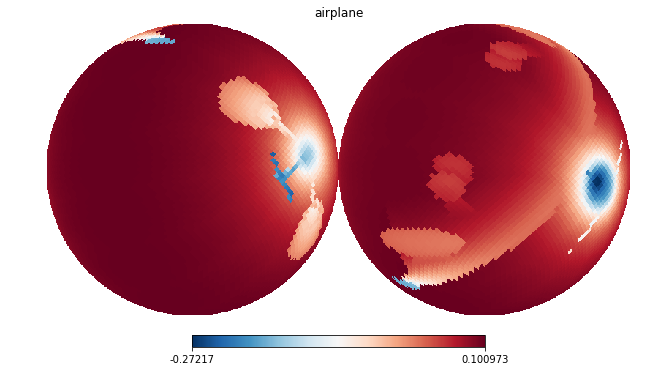

<Figure size 432x288 with 0 Axes>

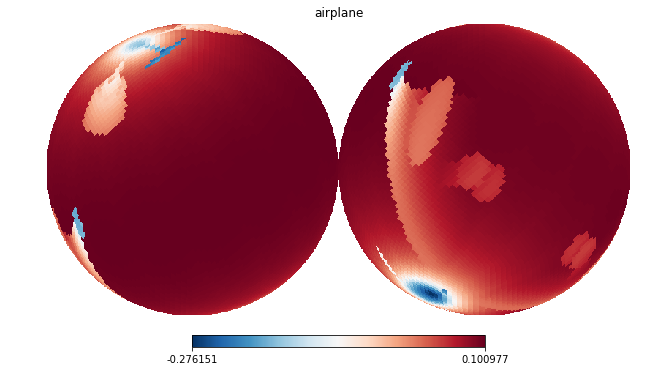

<Figure size 432x288 with 0 Axes>

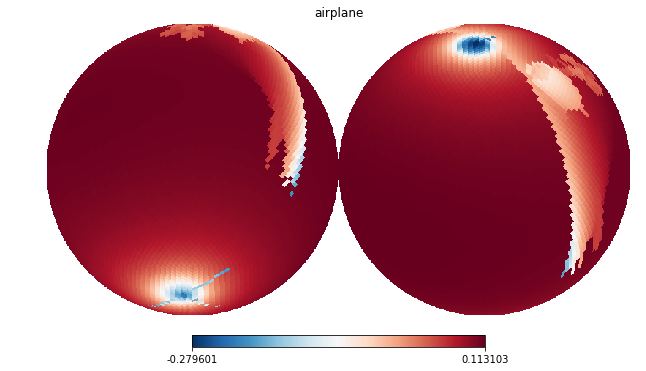

<Figure size 432x288 with 0 Axes>

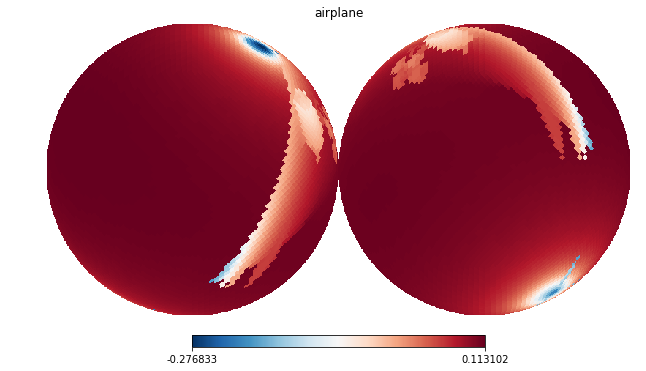

<Figure size 432x288 with 0 Axes>

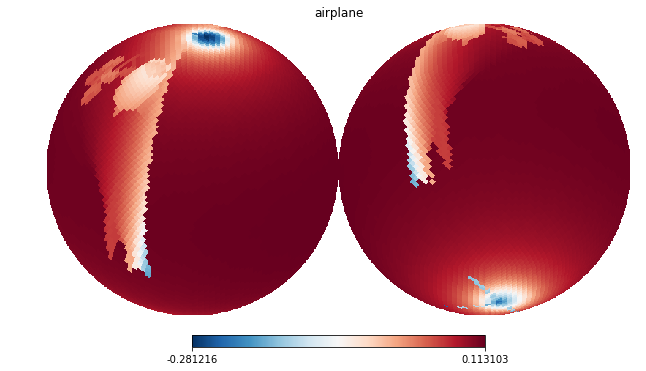

<Figure size 432x288 with 0 Axes>

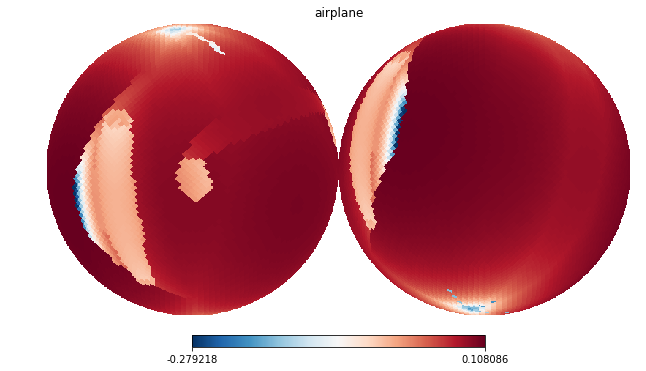

<Figure size 432x288 with 0 Axes>

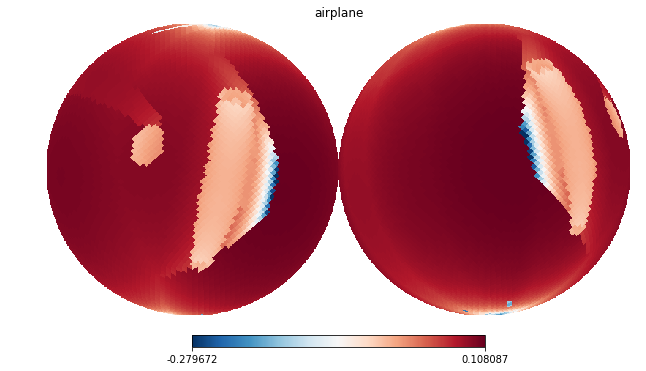

<Figure size 432x288 with 0 Axes>

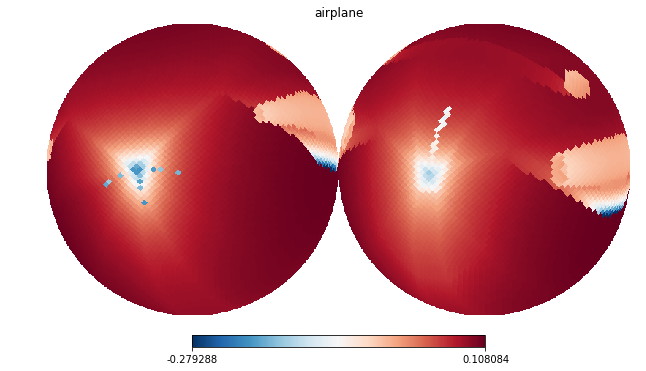

<Figure size 432x288 with 0 Axes>

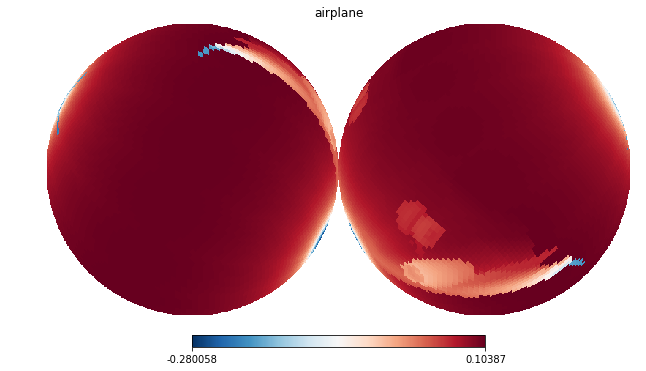

<Figure size 432x288 with 0 Axes>

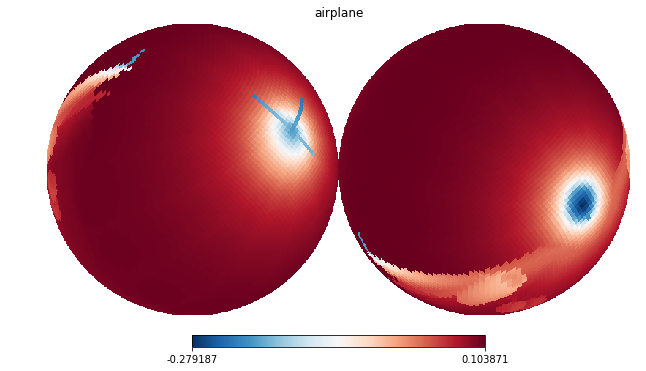

<Figure size 432x288 with 0 Axes>

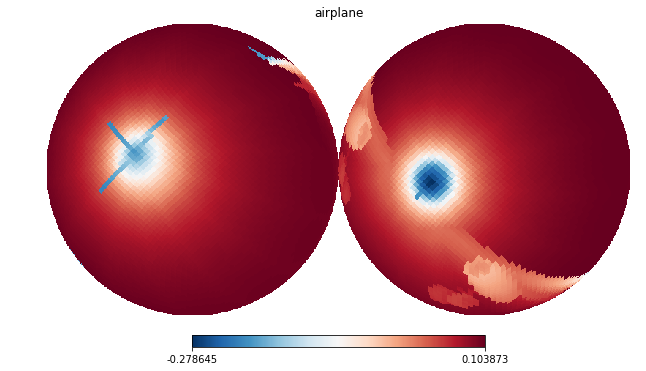

<Figure size 432x288 with 0 Axes>

In [20]:
from tqdm import tqdm
size = 1 # 32
steps = test_rot_no_dataset.N // size + 1
data_iter = test_rot_no_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
    im1 = data[0,:,0]
    cmin = np.nanmin(im1)
    cmax = np.nanmax(im1)
    hp.orthview(im1, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
    plt.figure()
    if i > 10:
        break

In [19]:
from tqdm import tqdm
size = 1 # 32
steps = test_rot_no_dataset.N // size + 1
data_iter = test_rot_dataset.iter(size)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
#     im1 = data[0,:,0]
#     cmin = np.nanmin(im1)
#     cmax = np.nanmax(im1)
#     hp.orthview(im1, rot=(0,0,0), title=test_rot_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
#     plt.figure()
#     if i > 10:
#         break

100%|██████████| 7405/7405 [00:12<00:00, 605.81it/s]


In [ ]:
from tqdm import tqdm
steps = train_rot_dataset.N // 32 + 1
data_iter = train_rot_dataset.iter(32)
cm = plt.cm.RdBu_r
cm.set_under('w')
for i in tqdm(range(steps)):
    data, label = next(data_iter)
#     im1 = data[0,:,0]
#     cmin = np.nanmin(im1)
#     cmax = np.nanmax(im1)
#     hp.orthview(im1, rot=(0,0,0), title=train_dataset.classes[label[0]], nest=True, cmap=cm, min=cmin, max=cmax)
#     break


  0%|          | 0/923 [00:00<?, ?it/s]
Exception in thread Thread-42:
Traceback (most recent call last):
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/tqdm/_tqdm.py", line 148, in run
    for instance in self.tqdm_cls._instances:
  File "/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

  0%|          | 2/923 [02:27<18:55:29, 73.97s/it]ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
  2%|▏         | 18/923 [19:49<16:37:05, 66.11s/it]ERROR:tri

ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
 12%|█▏        | 111/923 [2:21:52<17:17:49, 76.69s/it]ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
 12%|█▏        | 114/923 [2:24:17<17:03:58, 75.94s/it]ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
 12%|█▏        | 115/923 [2:26:36<17:10:03, 76.49s/it]ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
ERROR:trimesh:No adjacent faces detected! Did you merge vertices?
 13%|█▎        | 118/923 [2:29:33<17:00:14, 76.04s/it]ERROR:trimesh:No adjacent faces detected! Did you merge ve

## 1.1 Preprocess the dataset

Shuffle the training dataset and print the classes distribution

In [15]:
nclass = train_TFDataset.nclass
num_elem = train_TFDataset.N
print('number of class:',nclass,'\nnumber of elements:',num_elem)

number of class: 40 
number of elements: 29529


## 2 Classification using DeepSphere

In [22]:
EXP_NAME = 'MN40_rot_{}feat_{}aug_{}sides{}'.format(nfeat, augmentation, Nside, ename)
#EXP_NAME = 'shrec17_Cohen_simple_SGD_max_nsides_300epoch_{}sides{}'.format(Nside, ename)
#EXP_NAME = "shrec17_newGraph_best_4K_all_3aug_32sides_CNN"
#EXP_NAME = 'essai_TFDataset'

Load model with hyperparameters chosen.
For each experiment, a new EXP_NAME is chosen, and new hyperparameters are store.
All informations are present 'DeepSphere/Shrec17/experiments.md'
The fastest way to reproduce an experiment is to revert to the commit of the experiment to load the correct files and notebook

Adding a layer in the fully connected can be beneficial

In [23]:
params = hyperparameters.get_params_shrec17_optim(num_elem, EXP_NAME, Nside, nclass, nfeat_in=nfeat, architecture=experiment_type)
params["tf_dataset"] = train_TFDataset.get_tf_dataset(params["batch_size"])
#params["std"] = [0.001, 0.005, 0.0125, 0.05, 0.15, 0.5]
model = models.deepsphere(**params)

#sides: [32, 16, 8, 4, 2, 1, 1]
#pixels: [12288, 3072, 768, 192, 48, 12, 12]
#samples per batch: 32
=> #pixels per batch (input): 393,216
=> #pixels for training (input): 18,142,617,600
Learning rate will start at 2.0e-02 and finish at 2.0e-02.
NN architecture
  input: M_0 = 12288
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 12288 * 16 / 4 = 49152
    weights: F_0 * F_1 * K_1 = 6 * 16 * 4 = 384
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 3072 * 32 / 4 = 24576
    weights: F_1 * F_2 * K_2 = 16 * 32 * 4 = 2048
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 768 * 64 / 4 = 12288
    weights: F_2 * F_3 * K_3 = 32 * 64 * 4 = 8192
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 192 * 128 / 4 = 6144
    weights: F_3 * F_4 * K_4 = 64 * 128 * 4 = 32768
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
   

In [26]:
shutil.rmtree('summaries/{}/'.format(EXP_NAME), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(EXP_NAME), ignore_errors=True)

Find a correct learning rate

In [ ]:
backup = params.copy()

params, learning_rate = utils.test_learning_rates(params, train_TFDataset.N, 1e-6, 1e-1, num_epochs=20)

shutil.rmtree('summaries/{}/'.format(params['dir_name']), ignore_errors=True)
shutil.rmtree('checkpoints/{}/'.format(params['dir_name']), ignore_errors=True)

model = models.deepsphere(**params)
_, loss_validation, _, _ = model.fit(train_TFDataset, val_dataset, use_tf_dataset=True, cache=True)

params.update(backup)

plt.semilogx(learning_rate, loss_validation, '.-')

NN architecture
  input: M_0 = 196608
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 196608 * 16 / 4 = 786432
    weights: F_0 * F_1 * K_1 = 6 * 16 * 5 = 480
    biases: F_1 = 16
    batch normalization
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 49152 * 32 / 4 = 393216
    weights: F_1 * F_2 * K_2 = 16 * 32 * 5 = 2560
    biases: F_2 = 32
    batch normalization
  layer 3: cgconv3
    representation: M_2 * F_3 / p_3 = 12288 * 64 / 4 = 196608
    weights: F_2 * F_3 * K_3 = 32 * 64 * 5 = 10240
    biases: F_3 = 64
    batch normalization
  layer 4: cgconv4
    representation: M_3 * F_4 / p_4 = 3072 * 128 / 4 = 98304
    weights: F_3 * F_4 * K_4 = 64 * 128 * 5 = 40960
    biases: F_4 = 128
    batch normalization
  layer 5: cgconv5
    representation: M_4 * F_5 / p_5 = 768 * 256 / 4 = 49152
    weights: F_4 * F_5 * K_5 = 128 * 256 * 5 = 163840
    biases: F_5 = 256
    batch normalization
  Statistical layer: mean
    representation: 1 * 256 = 256
  layer 6: logits

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


  validation accuracy: 0.76 (39 / 5133), f1 (weighted): 0.80, loss: 4.29e+00
  CPU time: 1477s, wall time: 797s, perf_time_load: 1.16s, perf_time: 1.16s
step 980 / 19602 (epoch 1.00 / 20):
  learning_rate = 3.16e-06, training loss = 4.13e+00
  validation accuracy: 3.78 (194 / 5133), f1 (weighted): 2.88, loss: 4.19e+00
  CPU time: 2964s, wall time: 1587s, perf_time_load: 1.13s, perf_time: 1.13s
step 1470 / 19602 (epoch 1.50 / 20):
  learning_rate = 5.62e-06, training loss = 4.08e+00
  validation accuracy: 10.29 (528 / 5133), f1 (weighted): 4.54, loss: 4.00e+00
  CPU time: 4446s, wall time: 2374s, perf_time_load: 1.16s, perf_time: 1.16s
step 1960 / 19602 (epoch 2.00 / 20):
  learning_rate = 9.99e-06, training loss = 3.78e+00
  validation accuracy: 26.57 (1364 / 5133), f1 (weighted): 15.49, loss: 3.70e+00
  CPU time: 5924s, wall time: 3166s, perf_time_load: 1.15s, perf_time: 1.15s
step 2450 / 19602 (epoch 2.50 / 20):
  learning_rate = 1.78e-05, training loss = 3.08e+00
  validation accura

In [ ]:
shutil.rmtree('summaries/lr_finder/', ignore_errors=True)
shutil.rmtree('checkpoints/lr_finder/', ignore_errors=True)

0.9 seems to be a good learning rate for SGD with current parameters

## 2.2 Train Network

In [30]:
print("the number of parameters in the model is: {:,}".format(model.get_nbr_var()))

conv1/weights:0
conv1/bias:0
conv2/weights:0
conv2/bias:0
conv3/weights:0
conv3/bias:0
conv4/weights:0
conv4/bias:0
conv5/weights:0
conv5/bias:0
logits/weights:0
the number of parameters in the model is: 185,200


In [28]:
accuracy_validation, loss_validation, loss_training, t_step, t_batch = model.fit(train_TFDataset, 
                                                                                 test_dataset, 
                                                                                 use_tf_dataset=True, cache=True)

KeyboardInterrupt: 

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


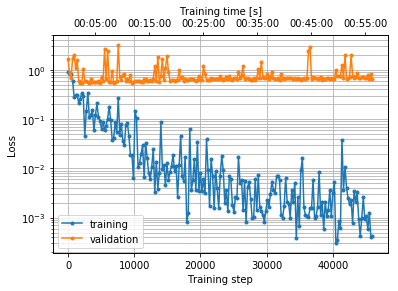

In [32]:
plot.plot_loss(loss_training, loss_validation, t_step, params['eval_frequency'])

Remarks

In [33]:
model.evaluate(train_rot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_6feat_3aug_32sides_CNN/model-46139


('accuracy: 78.57 (23201 / 29529), f1 (weighted): 78.35, loss: 7.99e-01\nCPU time: 92s, wall time: 86s',
 78.57021910664092,
 78.34749257320703,
 0.7994412581529597)

## test network

In [34]:
model.evaluate(test_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_6feat_3aug_32sides_CNN/model-46139


('accuracy: 87.56 (2161 / 2468), f1 (weighted): 87.63, loss: 6.62e-01\nCPU time: 6s, wall time: 5s',
 87.56077795786061,
 87.63398801088081,
 0.661834390631615)

In [35]:
model.evaluate(test_rot_dataset, None, cache=True)

/mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_6feat_3aug_32sides_CNN
INFO:tensorflow:Restoring parameters from /mnt/scratch/students/gusset/DeepSphere/deepsphere/../checkpoints/MN40_norot_6feat_3aug_32sides_CNN/model-46139


('accuracy: 69.71 (5161 / 7404), f1 (weighted): 69.51, loss: 1.35e+00\nCPU time: 23s, wall time: 21s',
 69.70556455969746,
 69.51364212439744,
 1.354613451088911)

Why not working?

In [18]:
def _print_histogram(nclass, labels_train, labels_min=None, ylim=1700):
    if labels_train is None:
        return
    import matplotlib.pyplot as plt
    from collections import Counter
    hist_train=Counter(labels_train)
    if labels_min is not None:
        hist_min = Counter(labels_min)
        hist_temp = hist_train - hist_min
        hist_min = hist_min - hist_train
        hist_train = hist_temp + hist_min
#         for i in range(self.nclass):
#             hist_train.append(np.sum(labels_train == i))
    labels, values = zip(*hist_train.items())
    indexes = np.asarray(labels)
#     miss = set(indexes) - set(labels)
#     if len(miss) is not 0:
#         hist_train.update({elem:0 for elem in miss})
#     labels, values = zip(*hist_train.items())
    width = 1
    plt.bar(labels, values, width)
    plt.title("labels distribution")
    plt.ylim(0,ylim)
    #plt.xticks(indexes + width * 0.5, labels)
    plt.show()

In [19]:
_print_histogram(40, labels_test)
_print_histogram(40, predictions)
_print_histogram(40, labels_test, predictions, ylim=120)

NameError: name 'labels_test' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
plt.spy(confusion_matrix(labels_test, predictions, range(55)), cmap = plt.cm.gist_heat_r)